# Project 2: Continuous Control
## Introduction

The goal of this project is to use a double-jointed arm to move to target locations in a continuous world and maintain its position at the target location for as many time steps as possible. The reward function provides a +0.1 reward for as many time steps as the agent's hand is in the target location.

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import copy
import random

from unityagents import UnityEnvironment
from collections import namedtuple, deque
from tqdm import tqdm_notebook
%matplotlib inline

## Set up the environment

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 20
Number of actions: 4
States look like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
States have length: 33


## D4PG Agent
For this agent, we elect to implement the Distributed Distributional Deep Deterministic Policy Gradients (D4PG) algorithm as developed by [Barth-Maron, Hoffman, et al.](https://arxiv.org/pdf/1804.08617.pdf). The D4PG model uses an Actor-Critic method based on the original Deep Deterministic Policy Gradients (DDPG) [paper](https://arxiv.org/pdf/1509.02971.pdf), but by using a distributional critic, the learning is more stable. In order to speed-up learning, since the algorithm is off-policy, we distribute the experience gathering task across 20 actors.

These actors are neural networks with 2 hidden layers which map states to action values and whose outputs are activated with a tanh activation to keep it in the range of \[-1, 1\]. The critic takes the form of a neural network which allows for the input of a tuple (state, action) and outputs the Q value of the pair.

In [5]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128):
        """
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of neurons in the first hidden layer
            fc2_units (int): Number of neurons in the second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values"""
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128):
        """
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of neurons in the first hidden layer
            fc2_units (int): Number of neurons in the second hidden layer
        """
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
    def forward(self, state, action):
        """Build a network that maps (state, action) -> Q values"""
        xs = F.leaky_relu(self.fc1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

In [6]:
class ReplayBuffer():
    """Buffer to replay experience tuples"""
    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize ReplayBuffer class
        
        Params
        ======
            action_size (int): Dimension of each action
            buffer_size (int): Length of replay buffer
            batch_size (int): Size of each training mini-batch.
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    def add_experience(self, state, action, reward, next_state, done):
        """Append an experience to memory"""
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)
        
    def sample(self):
        """Sample experiences from memory"""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the length of the memory"""
        return len(self.memory)


class OUNoise:
    """Ornstein-Uhlenbeck noise process to be added to the actions."""

    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class D4PG_Agent():
    def __init__(self, state_size, action_size, buffer_size=int(1e5), batch_size=1024, update_every = 4, 
                 num_actors=20, alpha=.0001, beta=.0005, gamma=.95, tau=1e-3, epsilon=.99):
        """ Initialize agent attributes
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            buffer_size (int): Size of replay buffer
            batch_size (int): Batch size for replay buffer
            num_actors(int): Number of simultaneous actors
            alpha (float): Learning rate for actor
            beta (float): Learning rate for critic
            tau (float): Soft update multiplier
            epsilon (float): Parameter for controlling exploration vs exploitation
        """
        self.num_actors = num_actors
        self.batch_size = batch_size
        self.update_every = update_every
        self.gamma = gamma
        self.epsilon = epsilon
        self.tau = tau
        self.local_actor = Actor(state_size, action_size).to(device)
        self.target_actor = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.local_actor.parameters(), lr=alpha)
        self.local_critic = Critic(state_size, action_size).to(device)
        self.target_critic = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.local_critic.parameters(), lr=beta)
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size)
        self.noise = OUNoise(action_size)
        self.timesteps = 0
            
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay buffer, use random sample from buffer to learn
        Params
        ======
            state (ndarray): State of the environment
            action (ndarray): Action chosen by the agent
            reward (ndarray): Reward given by the environment
            next_state (ndarray): Next state of the environment
            done (ndarray): Flag to indicate if the episode is finished after this action
        """
        self.timesteps += 1
        self.memory.add_experience(state, action, reward, next_state, done)
        update_target_net = False
        
        if len(self.memory) > self.batch_size and self.timesteps % self.update_every == 0:
            batch = self.memory.sample()
            if self.timesteps % (5 * self.update_every) == 0:
                update_target_net = True
            self.learn(batch, self.gamma, update_target_net)
                
    def act(self, state, add_noise=True):
        """Given a state, choose an action to take
        Params
        ======
            state (ndarray): State of the environment
            score (float): Current score
            max_score (float): Maximum possible score
            add_noise (bool): Flag indicating whether or not to add ou noise to the environment
        """
        state = torch.from_numpy(state).float().to(device)
        
        self.local_actor.eval() # Set local network to evaluation mode
        with torch.no_grad():
            action = self.local_actor(state).cpu().data.numpy()
        self.local_actor.train()
            
        if add_noise:
            action += [self.epsilon * self.noise.sample() for _ in range(self.num_actors)]
                
        return np.clip(action, -1, 1)
    
    def soft_update(self, local_model, target_model):
        """Soft update model parameters
        
        Params
        ======
            local_model (nn.Module): model to copy weights from
            target_model (nn.Module): model to copy weights to
        """
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1-self.tau)*target_param.data)
    
    def learn(self, batch, gamma, update_target_net=True):
        """ Given a batch of experiences, update the local network and soft update on target networks.
        Q = r + gamma * critic_target(next_state, actor_target(next_state))
        
        Params
        ======
            batch (tuple of tensors): Experiences - (states, actions, rewards, next_states, dones)
            gamma (float): Discount factor for rewards
            update_target_net (bool): Whether or not to update the target net (as opposed to local)
        """
        states, actions, rewards, next_states, dones = batch
        
        # Compute critic loss
        Q_expected = self.local_critic(states, actions)
        Q_target_next = self.target_critic(next_states, self.target_actor(next_states))
        Q_target = rewards + (gamma * Q_target_next * (1-dones))
        critic_loss = F.mse_loss(Q_expected, Q_target)
        
        # Minimize loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.local_critic.parameters(), 1)
        self.critic_optimizer.step()
        
        # Compute actor loss
        Q_local = self.local_critic(states, self.local_actor(states))
        actor_loss = - Q_local.mean()
        
        # Actor gradient ascent
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Reduce exploration
        self.epsilon *= self.epsilon
        
        # Soft update
        if update_target_net:
            self.soft_update(self.local_critic, self.target_critic)
            self.soft_update(self.local_actor, self.target_actor)
            
    def reset(self):
        self.epsilon = .99
        self.noise.reset()

## Train agent

In [8]:
agent = D4PG_Agent(state_size, action_size)

In [9]:
n_episodes = 500
current_score = 0
scores = list()
rolling_average = list()
score_deque = deque(maxlen=100)

for ep in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    agent.reset()
    episode_scores = np.zeros(agent.num_actors)
    for _ in range(800):
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        
        episode_scores += rewards
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            agent.step(state, action, reward, next_state, done)

        states = next_states
        if np.any(dones):
            break
            
    episode_score = np.mean(episode_scores)
    score_deque.append(episode_score)
    scores.append(episode_score)
    ra_current = np.mean(score_deque)
    rolling_average.append(ra_current)
    
    if ep == 1 or ep % 10 == 0:
        print("Episode {} complete! Average score: {:.2f}\tEpisode score: {:.2f}".format(ep, ra_current, episode_score))
    
    if ra_current >= 30 and len(score_deque) > 99:
        print("Target reward achieved in {} episodes! Average score: {:.2f}".format(ep, ra_current))
        break
        
torch.save(agent.target_actor.state_dict(), 'actor_solution.pth')
torch.save(agent.target_critic.state_dict(), 'critic_solution.pth')

Episode 1 complete! Average score: 0.48	Episode score: 0.48
Episode 10 complete! Average score: 0.75	Episode score: 0.83
Episode 20 complete! Average score: 1.29	Episode score: 2.91
Episode 30 complete! Average score: 4.07	Episode score: 14.05
Episode 40 complete! Average score: 9.08	Episode score: 30.04
Episode 50 complete! Average score: 13.39	Episode score: 30.64
Episode 60 complete! Average score: 16.25	Episode score: 29.63
Episode 70 complete! Average score: 18.23	Episode score: 30.32
Episode 80 complete! Average score: 19.75	Episode score: 30.03
Episode 90 complete! Average score: 20.94	Episode score: 29.69
Episode 100 complete! Average score: 21.84	Episode score: 30.98
Episode 110 complete! Average score: 24.79	Episode score: 30.31
Episode 120 complete! Average score: 27.59	Episode score: 29.09
Episode 130 complete! Average score: 29.62	Episode score: 30.23
Target reward achieved in 134 episodes! Average score: 30.070164


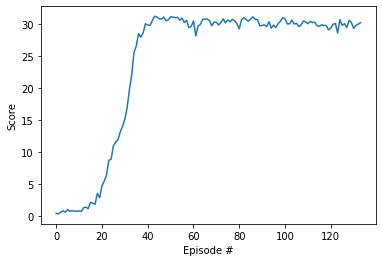

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('continuous_control_scores.png', bbox_inches='tight')
plt.show()